# Project Tasks

In the first two assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should try both combining the profiles with activities and using each data type independently.
* Implement different models of your choice for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier to predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session.

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially at the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [15]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

## Mutational catalogs and activities - WGS data

In [2]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [3]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
PCAWG_wgs_act["Cancer Types"].value_counts()

Cancer Types
Liver-HCC              326
Prost-AdenoCA          286
Panc-AdenoCA           241
Breast-AdenoCA         198
CNS-Medullo            146
Kidney-RCC             144
Ovary-AdenoCA          113
Skin-Melanoma          107
Lymph-BNHL             107
Eso-AdenoCA             98
Lymph-CLL               95
CNS-PiloAstro           89
Panc-Endocrine          85
Stomach-AdenoCA         75
ColoRect-AdenoCA        60
Head-SCC                57
Myeloid-MPN             56
Uterus-AdenoCA          51
Lung-SCC                48
Thy-AdenoCA             48
Kidney-ChRCC            45
CNS-GBM                 41
Bone-Osteosarc          38
Lung-AdenoCA            38
Biliary-AdenoCA         35
Bladder-TCC             23
SoftTissue-Liposarc     19
CNS-Oligo               18
Cervix-SCC              18
Bone-Benign             16
SoftTissue-Leiomyo      15
Breast-LobularCA        13
Bone-Epith              11
Myeloid-AML             11
Myeloid-MDS              4
Breast-DCIS              3
Cervix-AdenoCA 

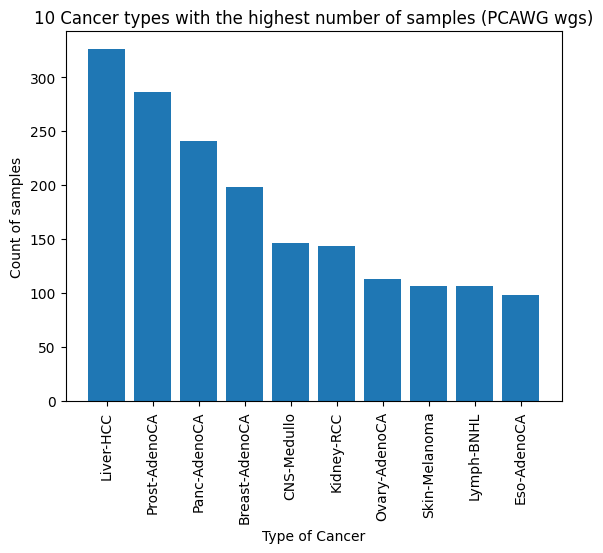

In [24]:
# added histogram for better visualization 
counts = PCAWG_wgs_act["Cancer Types"].value_counts().head(10)

plt.bar(counts.index, counts.values)
plt.xticks(rotation=90)
plt.xlabel("Type of Cancer")
plt.ylabel("Count of samples")
plt.title("10 Cancer types with the highest number of samples (PCAWG wgs)")
plt.show()

In [5]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,ALL::PD4020a,ALL::SJBALL011_D,ALL::SJBALL012_D,ALL::SJBALL020013_D1,ALL::SJBALL020422_D1,ALL::SJBALL020579_D1,ALL::SJBALL020589_D1,ALL::SJBALL020625_D1,...,Stomach-AdenoCa::pfg316T,Stomach-AdenoCa::pfg317T,Stomach-AdenoCa::pfg344T,Stomach-AdenoCa::pfg373T,Stomach-AdenoCa::pfg375T,Stomach-AdenoCa::pfg378T,Stomach-AdenoCa::pfg398T,Stomach-AdenoCa::pfg413T,Stomach-AdenoCa::pfg416T,Stomach-AdenoCa::pfg424T
0,C>A,ACA,35,9,2,7,5,7,3,5,...,133,185,202,185,96,134,12,279,75,135
1,C>A,ACC,16,2,4,10,5,9,1,2,...,48,70,126,88,35,54,16,112,31,91


In [6]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,...,0,0,0,0,0,0,0,0,0,0


## Mutational catalogs - WES data

In [7]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

,Mutation type,Trinucleotide,AML::TCGA-AB-2802-03B-01W-0728-08,AML::TCGA-AB-2803-03B-01W-0728-08,AML::TCGA-AB-2804-03B-01W-0728-08,AML::TCGA-AB-2805-03B-01W-0728-08,AML::TCGA-AB-2806-03B-01W-0728-08,AML::TCGA-AB-2807-03B-01W-0728-08,AML::TCGA-AB-2808-03B-01W-0728-08,AML::TCGA-AB-2809-03D-01W-0755-09,...,Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08
0,C>A,ACA,0,0,0,0,4,0,2,0,...,1,0,0,0,0,0,0,0,0,0
1,C>A,ACC,0,2,0,0,0,1,3,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,AML,TCGA-AB-2802-03B-01W-0728-08,0.811,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AML,TCGA-AB-2803-03B-01W-0728-08,0.608,4,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
TCGA_wes_act["Cancer Types"].value_counts()

Cancer Types
Breast-cancer                  930
Lung-AdenoCa                   528
DLBC                           512
ColoRect-AdenoCa               496
Prost-AdenoCa                  484
Thy-AdenoCa                    478
Uterus-AdenoCa                 474
Head-SCC                       464
Lung-SCC                       427
Skin-Melanoma                  412
Stomach-AdenoCa                401
Transitional-cell-carcinoma    389
Ovary-AdenoCa                  385
CNS-GBM                        362
Kidney-RCC                     334
Liver-HCC                      311
Cervix-CA                      271
Kidney-Papillary               251
Sarcoma                        208
Pheochromocytoma               182
Eso-AdenoCa                    182
Panc-AdenoCa                   174
Testis-Ca                      149
AML                            139
Thymoma                        123
Adrenal-neoplasm                91
Mesothelium-Mesothelioma        82
Eye-Melanoma                    80
UCS    

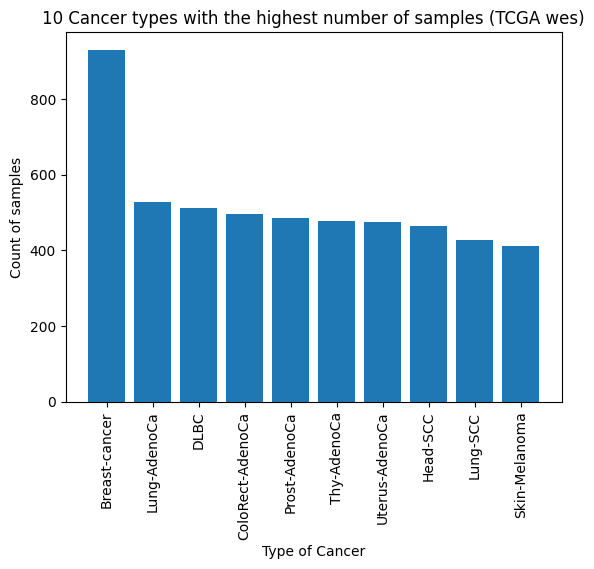

In [26]:
# added histogram for better visualization 
counts = TCGA_wes_act["Cancer Types"].value_counts().head(10)

plt.bar(counts.index, counts.values)
plt.xticks(rotation=90)
plt.xlabel("Type of Cancer")
plt.ylabel("Count of samples")
plt.title("10 Cancer types with the highest number of samples (TCGA wes)")
plt.show()

In [10]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

,Mutation type,Trinucleotide,ALL::TARGET-10-PAIXPH-03A-01D,ALL::TARGET-10-PAKHZT-03A-01R,ALL::TARGET-10-PAKMVD-09A-01D,ALL::TARGET-10-PAKSWW-03A-01D,ALL::TARGET-10-PALETF-03A-01D,ALL::TARGET-10-PALLSD-09A-01D,ALL::TARGET-10-PAMDKS-03A-01D,ALL::TARGET-10-PAPJIB-04A-01D,...,Head-SCC::V-109,Head-SCC::V-112,Head-SCC::V-116,Head-SCC::V-119,Head-SCC::V-123,Head-SCC::V-124,Head-SCC::V-125,Head-SCC::V-14,Head-SCC::V-29,Head-SCC::V-98
0,C>A,ACA,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
1,C>A,ACC,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [11]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,TARGET-10-PAIXPH-03A-01D,0.529,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,ALL,TARGET-10-PAKHZT-03A-01R,0.696,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [12]:
other_wes_act["Cancer Types"].unique()

array(['ALL', 'AML', 'Adrenal-neoplasm', 'Biliary-AdenoCa', 'Bladder-TCC',
       'Blood-CMDI', 'Breast-Fibroadenoma', 'Breast-cancer', 'CNS-GBM',
       'CNS-LGG', 'CNS-Medullo', 'CNS-glioma-NOS', 'ColoRect-AdenoCa',
       'ColoRect-Adenoma', 'Eso-AdenoCa', 'Eso-SCC', 'Ewings',
       'Eye-Melanoma', 'Eye-RB', 'Head-SCC', 'Kidney-ChRCC', 'Kidney-NOS',
       'Kidney-Papillary', 'Kidney-RCC', 'Kidney-Wilms', 'Liver-Benign',
       'Liver-HCC', 'Lung-AdenoCa', 'Lung-Carcinoid', 'Lung-NOS',
       'Lung-SCC', 'Lung-Small', 'Lymph-BNHL', 'Lymph-CLL', 'Lymph-NOS',
       'Lymph-TNHL', 'Lymph-cHL', 'Meninges-Meningioma',
       'Mesothelium-Mesothelioma', 'Neuroblastoma', 'Oral-SCC',
       'Ovary-AdenoCa', 'Panc-AdenoCa', 'Panc-Endocrine', 'Panc-Other',
       'Para-AdenoCa', 'Para-Adenoma', 'Pit-All', 'Prost-AdenoCa',
       'Prost-Adenoma', 'Sarcoma-bone', 'Sarcoma', 'Skin-BCC',
       'Skin-Melanoma', 'Skin-SCC', 'Small-Intestine-carcinoid',
       'Stomach-AdenoCa', 'Testis-Ca', 'Thy-

## My attempt

In [13]:
# Keep the 96 channels as rows, samples as columns
meta_cols = ["Mutation type", "Trinucleotide"]
sample_cols = [c for c in TCGA_wes_mut.columns if c not in meta_cols]
channel_names = (TCGA_wes_mut["Mutation type"].astype(str) + "_" + TCGA_wes_mut["Trinucleotide"].astype(str)).tolist()

X_catalog = TCGA_wes_mut[sample_cols].to_numpy().T
X_catalog = pd.DataFrame(X_catalog, index=sample_cols, columns=channel_names)
X_catalog_norm = X_catalog.div(X_catalog.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0) # normalize
X_catalog_norm.head()

,C>A_ACA,C>A_ACC,C>A_ACG,C>A_ACT,C>A_CCA,C>A_CCC,C>A_CCG,C>A_CCT,C>A_GCA,C>A_GCC,...,T>G_CTG,T>G_CTT,T>G_GTA,T>G_GTC,T>G_GTG,T>G_GTT,T>G_TTA,T>G_TTC,T>G_TTG,T>G_TTT
AML::TCGA-AB-2802-03B-01W-0728-08,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.066667,0.0,0.0,0.0,0.0
AML::TCGA-AB-2803-03B-01W-0728-08,0.00000,0.111111,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
AML::TCGA-AB-2804-03B-01W-0728-08,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
AML::TCGA-AB-2805-03B-01W-0728-08,0.00000,0.000000,0.000000,0.012658,0.000000,0.012658,0.012658,0.000000,0.000000,0.00000,...,0.0,0.012658,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
AML::TCGA-AB-2806-03B-01W-0728-08,0.00597,0.000000,0.004478,0.002985,0.029851,0.026866,0.014925,0.028358,0.008955,0.01194,...,0.0,0.001493,0.0,0.0,0.001493,0.000000,0.0,0.0,0.0,0.0


In [ ]:
y = TCGA_wes_act["Cancer Types"].astype(str)
barcodes = TCGA_wes_act["Sample Names"].astype(str)
drop_cols = ["Cancer Types", "Sample Names"]
X_act = TCGA_wes_act.drop(columns=drop_cols)

# Optional: drop "Accuracy"? if We treat it as a QC/confounder rather than biological signal
if "Accuracy" in X_act.columns:
    X_act_noacc = X_act.drop(columns=["Accuracy"])
else:
    X_act_noacc = X_act

X_act_noacc.index = barcodes
y.index = barcodes
X_act_noacc.head()

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
Sample Names,,,,,,,,,,,,,,,,,,,,,
TCGA-AB-2802-03B-01W-0728-08,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-AB-2803-03B-01W-0728-08,4,0,0,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-AB-2804-03B-01W-0728-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-AB-2805-03B-01W-0728-08,12,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-AB-2806-03B-01W-0728-08,40,0,0,0,337,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
def extract_barcode(s):
    return s.split("::", 1)[-1]

X_catalog_norm = X_catalog_norm.copy()
X_catalog_norm["barcode"] = [extract_barcode(s) for s in X_catalog_norm.index]
X_catalog_norm = X_catalog_norm.set_index("barcode")

# Intersect
common = X_catalog_norm.index.intersection(X_act_noacc.index)

Xc = X_catalog_norm.loc[common]
Xa = X_act_noacc.loc[common]
y_common = y.loc[common]

print(Xc.shape, Xa.shape, y_common.shape)

(9493, 96) (9493, 65) (9493,)


In [13]:
X_combined = pd.concat([Xc, Xa], axis=1)
X_combined.head()

,C>A_ACA,C>A_ACC,C>A_ACG,C>A_ACT,C>A_CCA,C>A_CCC,C>A_CCG,C>A_CCT,C>A_GCA,C>A_GCC,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
TCGA-AB-2802-03B-01W-0728-08,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0,0,0,0,0,0,0,0,0,0
TCGA-AB-2803-03B-01W-0728-08,0.00000,0.111111,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.00000,...,0,0,0,0,0,0,0,0,0,0
TCGA-AB-2804-03B-01W-0728-08,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0,0,0,0,0,0,0,0,0,0
TCGA-AB-2805-03B-01W-0728-08,0.00000,0.000000,0.000000,0.012658,0.000000,0.012658,0.012658,0.000000,0.000000,0.00000,...,0,0,0,0,0,0,0,0,0,0
TCGA-AB-2806-03B-01W-0728-08,0.00597,0.000000,0.004478,0.002985,0.029851,0.026866,0.014925,0.028358,0.008955,0.01194,...,0,0,0,0,0,0,0,0,0,0


In [15]:
from sklearn.model_selection import train_test_split

X = X_combined
X_train, X_test, y_train, y_test = train_test_split(
    X, y_common,
    test_size=0.2,
    random_state=0,
    stratify=y_common
)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

models = {
    "logreg_l2": Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", LogisticRegression(
            solver="saga",
            penalty="l2",
            max_iter=5000,
            n_jobs=-1
        ))
    ]),
    "linear_svm": Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", LinearSVC(C=1.0))
    ]),
    "hgb": HistGradientBoostingClassifier(random_state=0)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_common))
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results[name] = {"cm": cm, "report": report}
    print("\n===", name, "===")
    print(classification_report(y_test, y_pred, zero_division=0))

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



=== logreg_l2 ===
                             precision    recall  f1-score   support

                        AML       0.46      0.43      0.44        28
           Adrenal-neoplasm       0.10      0.06      0.07        18
            Biliary-AdenoCa       0.00      0.00      0.00         7
              Breast-cancer       0.52      0.62      0.57       186
                    CNS-GBM       0.55      0.53      0.54        72
                  Cervix-CA       0.52      0.43      0.47        54
           ColoRect-AdenoCa       0.62      0.67      0.64        99
                       DLBC       0.56      0.61      0.58       103
                Eso-AdenoCa       0.65      0.56      0.60        36
               Eye-Melanoma       0.20      0.12      0.15        16
                   Head-SCC       0.41      0.39      0.40        93
               Kidney-ChRCC       0.50      0.40      0.44        10
           Kidney-Papillary       0.60      0.56      0.58        50
              

/opt/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== linear_svm ===
                             precision    recall  f1-score   support

                        AML       0.80      0.43      0.56        28
           Adrenal-neoplasm       0.33      0.11      0.17        18
            Biliary-AdenoCa       0.00      0.00      0.00         7
              Breast-cancer       0.44      0.70      0.54       186
                    CNS-GBM       0.43      0.51      0.47        72
                  Cervix-CA       0.47      0.28      0.35        54
           ColoRect-AdenoCa       0.52      0.76      0.62        99
                       DLBC       0.53      0.59      0.56       103
                Eso-AdenoCa       0.86      0.53      0.66        36
               Eye-Melanoma       0.38      0.38      0.38        16
                   Head-SCC       0.41      0.26      0.32        93
               Kidney-ChRCC       0.67      0.20      0.31        10
           Kidney-Papillary       0.61      0.46      0.52        50
             

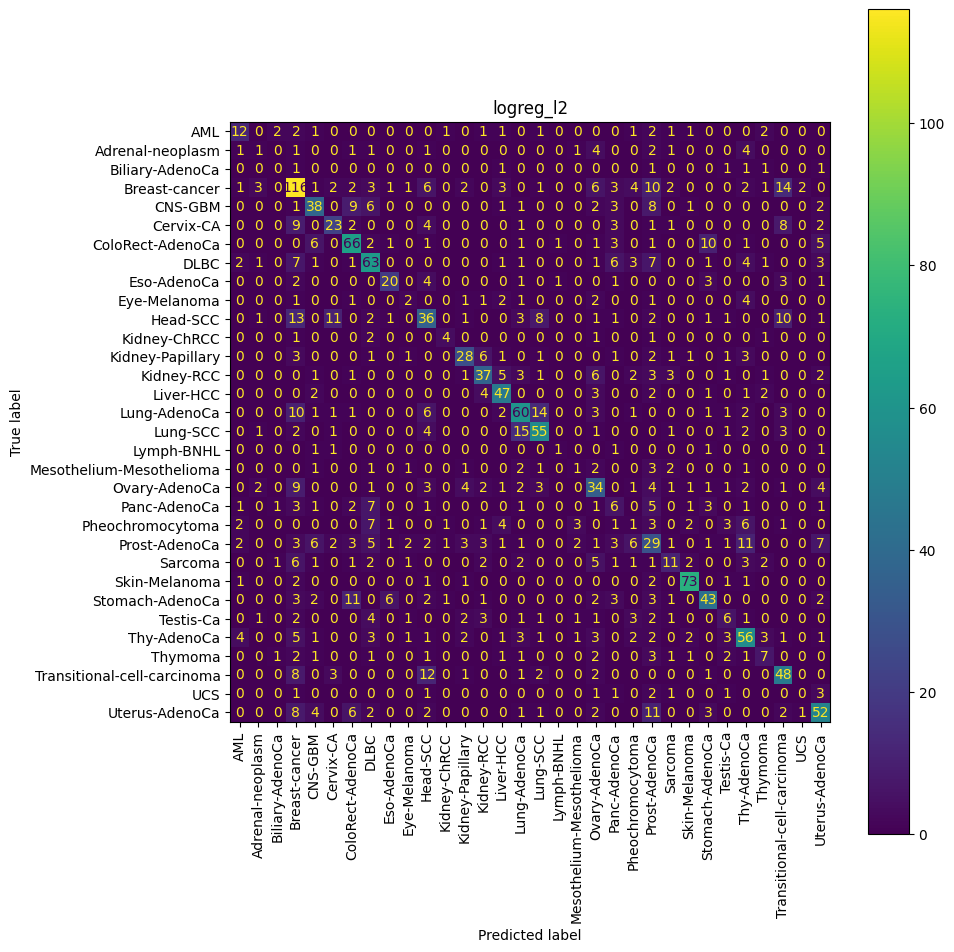

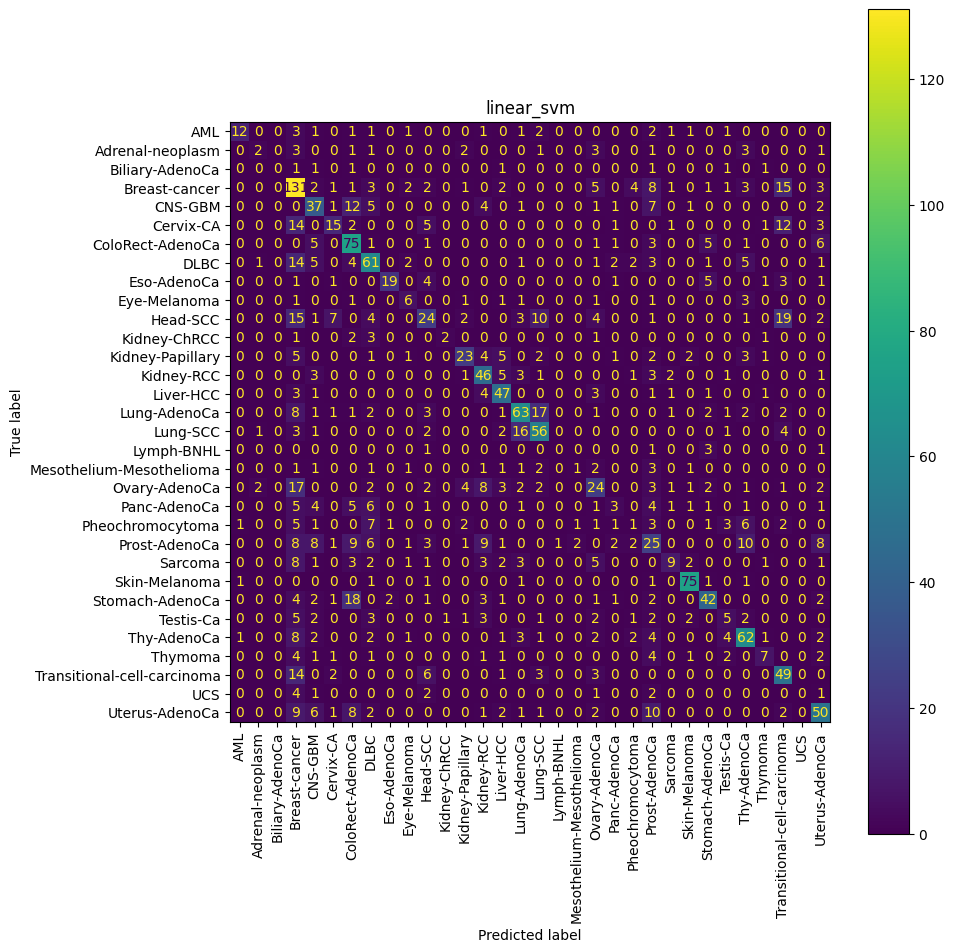

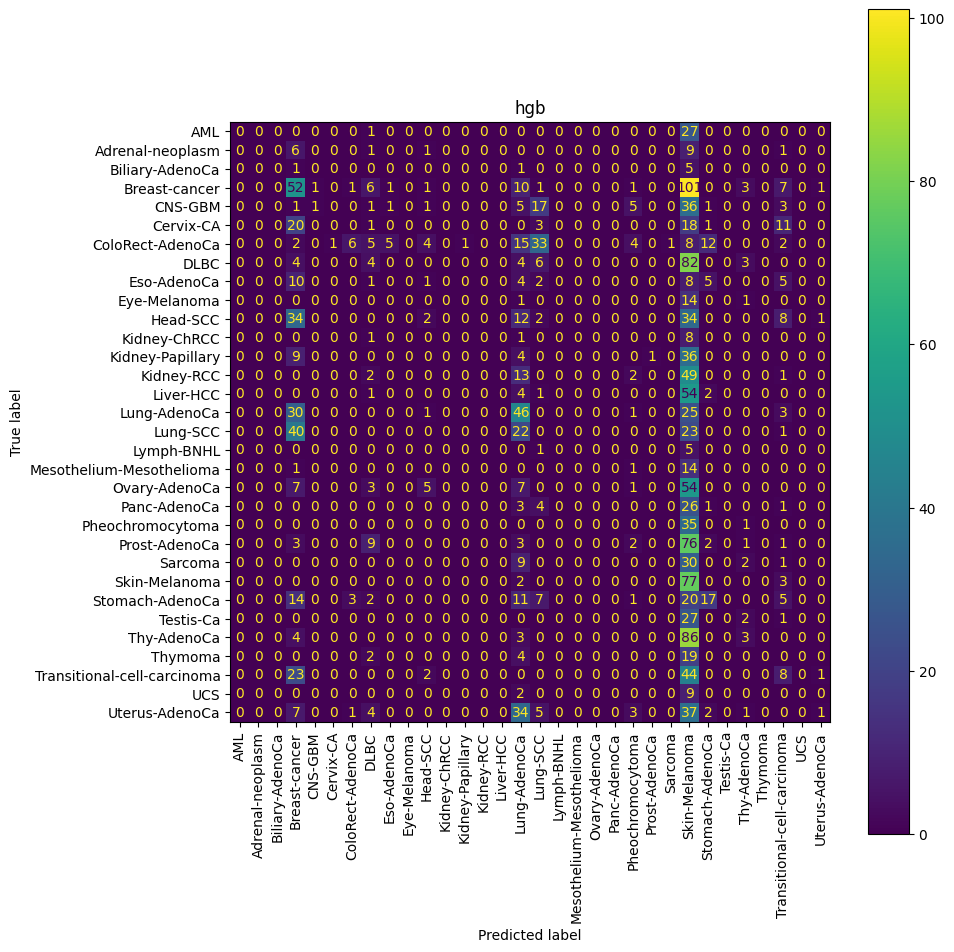

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = np.unique(y_common)

for name in models:
    disp = ConfusionMatrixDisplay(results[name]["cm"], display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, xticks_rotation=90, values_format="d")
    plt.title(name)
    plt.tight_layout()
    plt.show()

In [24]:
# Which features are informative? 
logreg = models["logreg_l2"].named_steps["clf"]
coef = logreg.coef_  # shape: n_classes x n_features
importance = np.linalg.norm(coef, axis=0)
imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
imp.head(10)

SBS5     14.950277
SBS40    10.450112
SBS30     7.115239
SBS1      6.517197
SBS45     5.447854
SBS13     5.438553
SBS3      5.195389
SBS2      4.433353
SBS44     4.350350
SBS36     3.734984
dtype: float64

In [25]:
logreg = models["linear_svm"].named_steps["clf"]
coef = logreg.coef_  # shape: n_classes x n_features
importance = np.linalg.norm(coef, axis=0)
imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
imp.head(10)

SBS5     7.528388
SBS45    5.801782
SBS13    4.992491
SBS2     4.471413
SBS3     4.361295
SBS1     4.322834
SBS40    3.929032
SBS15    3.008311
SBS30    2.944176
SBS44    2.828869
dtype: float64